Extract statistics and contributors picture from the GitHub repository

In [61]:
import datetime
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import requests
import yaml

from dateutil.relativedelta import relativedelta
from github import Github
from pathlib import Path
from PIL import Image

1. Generate a Personal access tokens on GitHub (in Setting)
2. Add it to the `../config.yaml` after `github:`

In [62]:
with open("../config.yaml", "r") as stream:
    config = yaml.load(stream)

In [63]:
# connect to GitHub
g = Github(config["github"])
# retrieve the hub repository
training_repo = g.get_user("galaxyproject").get_repo("training-material")

In [64]:
def format_str_date(date_str):
    '''
    Take a date as a string and reformat it to get the month and year as a string
    
    :param date_str: 
    
    :return:     
    '''
    #date = datetime.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    #return "{:%B %Y}".format(date)
    return datetime.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")


def format_date(date):
    '''
    Format date to put it at the begin of the month
    '''
    first_day = date.replace(day = 1)
    first_day = first_day.replace(hour = 0)
    first_day = first_day.replace(minute = 0)
    first_day = first_day.replace(second = 1)
    return first_day

In [65]:
# creation date at GCC2016
creation_date = format_str_date("2016-06-01 00:00:01")
# generate a data range with month (first day of the month)
data_range = pd.date_range(
    format_date(creation_date),
    format_date(datetime.datetime.now() + relativedelta(months=1)),
    freq=pd.tseries.offsets.DateOffset(months=1))

In [66]:
bg_col = (config["bg_col"]["r"], config["bg_col"]["g"], config["bg_col"]["b"])

# Extract and plot the number of contributions (commits, PR and issues) over the months

In [67]:
# extract the contributions per months
contrib = pd.DataFrame(0, columns=["commit_nb","pull_request", "issue"], index=data_range)

In [68]:
# extract the number of commits
for commit in training_repo.get_commits():
    date = format_date(commit.commit.author.date)
    contrib.iloc[contrib.index.get_loc(date, method='nearest')].commit_nb += 1

In [69]:
# extract the number of Pull Requests (all: open and closed ones)
for pr in training_repo.get_pulls(state="all"):
    date = format_date(pr.created_at)
    contrib.iloc[contrib.index.get_loc(date, method='nearest')].pull_request += 1

In [70]:
# extract the number of Issues (all: open and closed ones)
for issue in training_repo.get_issues(state="all"):
    # not counting the issues that are PR
    if issue.pull_request is not None:
        continue
    date = format_date(issue.created_at)
    contrib.iloc[contrib.index.get_loc(date, method='nearest')].issue += 1

In [71]:
# rename the columns
contrib = contrib.rename(columns = {
    "commit_nb": "Commits",
    "pull_request": "Pull Requests",
    "issue": "Issues"})

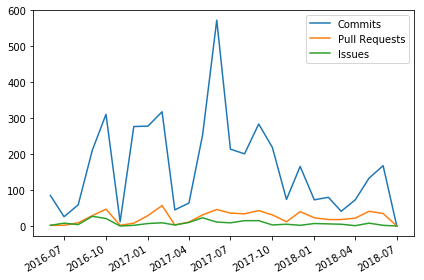

In [72]:
# plot the number of contributions
ax = contrib.plot(x_compat=True)
plt.tight_layout()
ax.set_facecolor(bg_col)
plt.savefig("../images/contributions.png", facecolor=bg_col, transparent=True)

# Extract and plot the number of contributors over the months

In [73]:
# extract the contributors per months
contributors = pd.DataFrame(0, columns=["first_contribution"], index=data_range)

In [74]:
# parse the contributors
for contri in training_repo.get_contributors():
    # extract the first commit by parsing the commits
    first_commit = datetime.datetime.now()
    commit_number = 0 
    for commit in training_repo.get_commits(author=contri):
        commit_date = commit.commit.author.date
        if commit_date < first_commit:
            first_commit = commit_date
    # add the a value for this date
    date = format_date(first_commit)
    contributors.iloc[contributors.index.get_loc(date, method='nearest')].first_contribution += 1

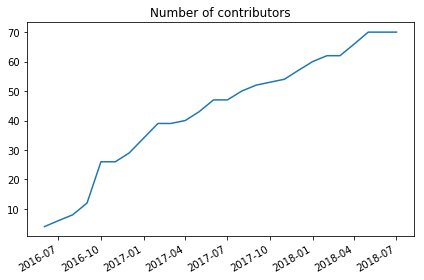

In [75]:
ax = contributors.first_contribution.cumsum().plot(x_compat=True, title="Number of contributors")
# fit the plot to the figure
plt.tight_layout()
ax.set_facecolor(bg_col)
plt.savefig("../images/contributor_nb.png", facecolor=bg_col, transparent=True)

# Create an image composed of the avatar of all the contributors

In [76]:
avatar_dir = Path("../images/avatars")
avatar_dir.mkdir(parents=True, exist_ok=True)

In [77]:
avatar_paths = []
# parse the contributors
for contri in training_repo.get_contributors():
    # get the url to the avatar
    avatar_url = contri.avatar_url
    # download the avatar with requests
    avatar_filename = "%s.png" % contri.login
    avatar_path = avatar_dir / Path(avatar_filename)
    if not avatar_path.is_file():
        r = requests.get(avatar_url, stream=True)
        r.raise_for_status()
        with open(avatar_path, "ab") as fd:
            for chunk in r.iter_content(chunk_size=128):
                fd.write(chunk)
    # add the path to the list of image paths
    avatar_paths.append(avatar_path)

In [78]:
def extract_resizing_value(x, y, n):
    '''
    Extracting the resizing value using the algo in
    https://math.stackexchange.com/questions/466198/algorithm-to-get-the-maximum-size-of-n-squares-that-fit-into-a-rectangle-with-a

    param x: width of the rectangle
    param y: height of the rectangle
    param n: number of square to fit in the (x,y) rectangle
    '''
    px = math.ceil(math.sqrt(n*x/y))
    py = math.ceil(math.sqrt(n*y/x))
    if math.floor(px*y/x)*px < n:
        sx = y/math.ceil(px*y/x)
    else:
        sx = x/px
    if math.floor(py*x/y)*py < n:
        sy = x/math.ceil(x*py/y)
    else:
        sy = y/py
    return math.floor(max(sx, sy))

In [79]:
# create image to combine the avatars
result = Image.new("RGB", (config["width"], config["height"]))
# extract the resizing value
img_nb = len(avatar_paths)
print("img nb: %s" % img_nb)
new_size = extract_resizing_value(
    config["width"],
    config["height"],
    img_nb)
print("new size: %s" % new_size)
# extract the number of row and number of column
col_nb = math.floor(config["width"] / new_size)
row_nb = math.floor(config["height"] / new_size)
print("col: %s, row: %s" % (col_nb, row_nb))
# compute extra pixels
extra_left_right_pixels = config["width"] - col_nb*new_size
extra_top_down_pixels = config["height"] - row_nb*new_size
print("top-down: %s, left-right: %s" % (extra_top_down_pixels, extra_left_right_pixels))
d_left = math.ceil(extra_left_right_pixels/2)
d_top = math.ceil(extra_top_down_pixels/2)
# find how many rectangles will be empty
empty_rect_nb = col_nb*row_nb - img_nb
# add as many empty path as many empty rectangles
avatar_paths += [""] * empty_rect_nb
# randomize the list of path
random.shuffle(avatar_paths)
# resize and add avatar
for index, filename in enumerate(avatar_paths):
    # if empty path: add nothing
    if not os.path.exists(filename):
        continue
    # load and resize the image
    img = Image.open(filename)
    resized_img = img.resize((new_size, new_size))
    # extract the position of the image in the rectangle
    x = index // row_nb * new_size + d_left
    y = index % row_nb * new_size + d_top
    # add the image
    result.paste(resized_img, (x, y, x + new_size, y + new_size))
# export the image
result.save("../images/contributors.png")

img nb: 70
new size: 128
col: 11, row: 7
top-down: 4, left-right: 32


![]("../images/contributors.png")